In [1]:
import os
import cv2
import json
import numpy as np
import random
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms
import matplotlib.pyplot as plt

In [2]:
from models_lib.pose_model import SimCC, PoseSimCC
from loc_utils.human_detection import detect_humans, draw_bboxes, crop_human_regions

## YOLO v5 for human detection

In [3]:
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\ADMIN/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-8-24 Python-3.11.9 torch-2.4.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


C:\Users\ADMIN/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:869: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


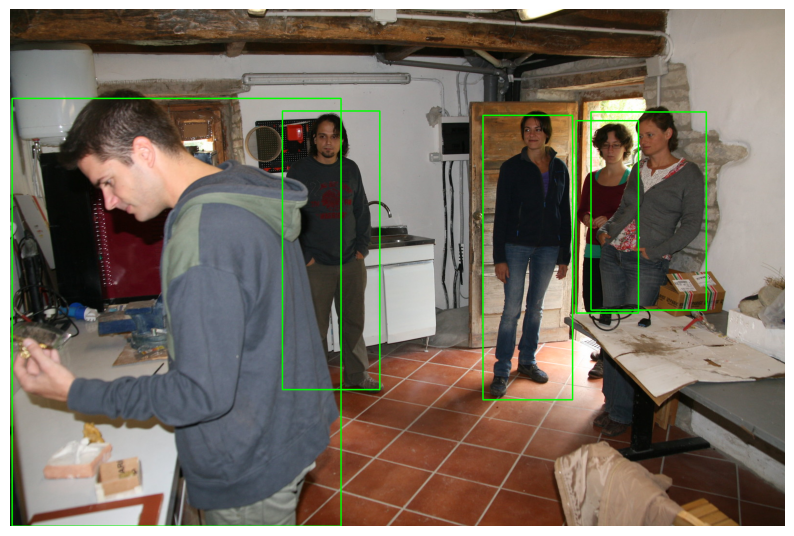

In [4]:
%matplotlib inline
img_path = './test_images/people1.jpg'
img, bboxes = detect_humans(yolo, img_path)
draw_bboxes(img, bboxes)

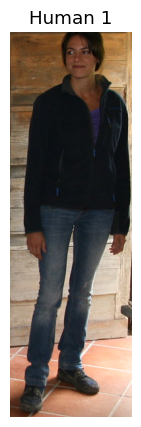

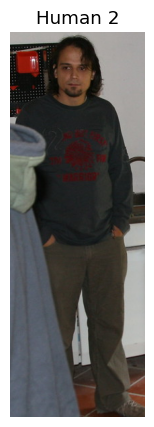

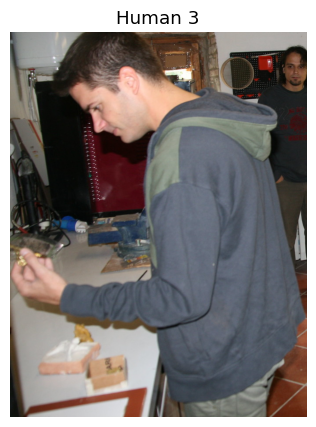

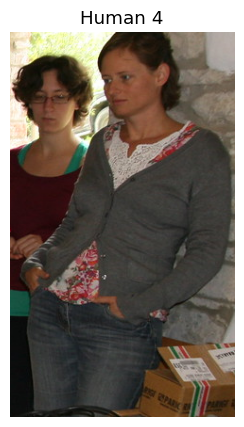

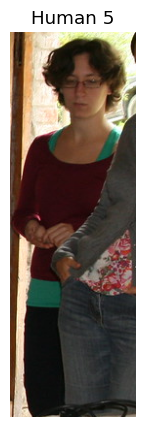

In [5]:
%matplotlib inline
human_images = crop_human_regions(img, bboxes)

# Display cropped human images
for idx, human_img in enumerate(human_images):
    plt.figure(figsize=(5, 5))
    plt.imshow(human_img)
    plt.axis('off')
    plt.title(f'Human {idx + 1}')
    plt.show()

## Pose Model

In [6]:
model_path = './model/pose_simcc_192x256.pth'

deconv_layers_cfg = {
    'num_layers': 2,
    'num_filters': [1024, 512],
    'kernel_sizes': [4, 4],
    'with_bias': False
}

model = PoseSimCC(num_joints=17, input_size=(192, 256), sigma=20.0, split_ratio=4.0, deconv_layers_cfg=deconv_layers_cfg)
model.load_state_dict(torch.load(model_path))

print("Model loaded from", model_path)

Model loaded from ./model/pose_simcc_192x256.pth


## Visualize inference

In [7]:
def visualize_single_image_with_simcc_labels(image, keypoints, simcc_x, simcc_y, split_ratio, 
                                             visibility=None, 
                                             keypoint_names=None, 
                                             orig_size=None, 
                                             orig_img=None, 
                                             bboxes=None
                                            ):
    image = image.numpy().transpose(1, 2, 0)  # Convert from CHW to HWC format
    image = (image * 255).astype(np.uint8)
    num_keypoints = simcc_x.shape[0]
    
    fig, axs = plt.subplots(17 // 5 + 1, 5, figsize=(15, (17//5 + 1) * 3))
    axs = axs.flatten()
    
    # Show original image
    axs[0].imshow(image)
    axs[0].axis('off')
    axs[0].set_title('Original Image')
    
    # Process and show heatmaps
    for i in range(num_keypoints):
        x_dist = simcc_x[i]
        y_dist = simcc_y[i]

        heatmap = np.zeros((len(y_dist), len(x_dist)))
        for y in range(len(y_dist)):
            for x in range(len(x_dist)):
                heatmap[y, x] = min(y_dist[y], x_dist[x])
        
        heatmap = F.interpolate(
            torch.tensor(heatmap).unsqueeze(0).unsqueeze(0),
            scale_factor=1.0/split_ratio,
            mode='bilinear',
            align_corners=False
        ).squeeze().numpy()

        min_val = heatmap.min()
        max_val = heatmap.max()
        if max_val > min_val:
            heatmap = (heatmap - min_val) / (max_val - min_val)  # Normalize the heatmap
        
        heatmap = np.clip(heatmap, 0, 1)

        heatmap_color = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)  # Convert to color heatmap
        heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

        heatmap_color = heatmap_color.astype(np.uint8)
        
        # Create a blended image with transparency
        blended_image = cv2.addWeighted(image.copy(), 0.4, heatmap_color, 0.6, 0)
        
        axs[i + 1].imshow(blended_image)
        axs[i + 1].axis('off')
        axs[i + 1].set_title(f'Heatmap {i+1}')        

    keypoints_image = cv2.resize(image.copy(), (orig_size[1], orig_size[0]))
    if keypoint_names is not None:
        for idx in range(keypoints.shape[0]):
            x, y = keypoints[idx]
            x *= orig_size[1] / image.shape[1]
            y *= orig_size[0] / image.shape[0]
            
            vis = visibility[idx]
            if x > 0 and y > 0 and vis > 0.16:
                cv2.circle(keypoints_image, (int(x), int(y)), 5, (0, 255, 0), -1)
                label = keypoint_names[idx]
                cv2.putText(keypoints_image, label, (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1, cv2.LINE_AA)

                x_min, y_min, x_max, y_max = map(int, bboxes)
                x += x_min
                y += y_min
                cv2.circle(orig_img, (int(x), int(y)), 5, (0, 255, 0), -1) 

        plt.figure(figsize=(10, 10))
        plt.imshow(keypoints_image)
        plt.axis('off')
        plt.title('Keypoints on Image')
        plt.show()
    else :
        plt.tight_layout()
        plt.show()

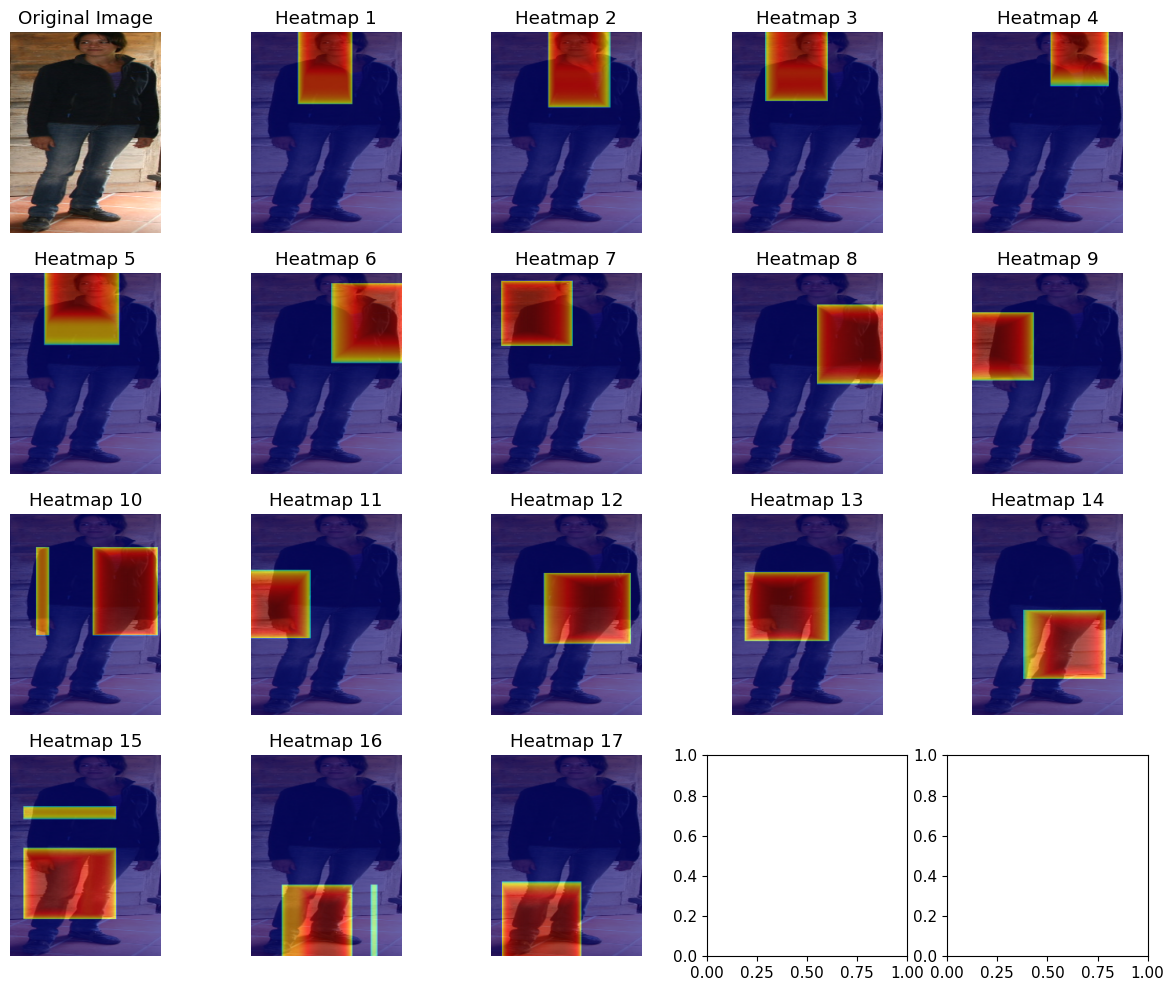

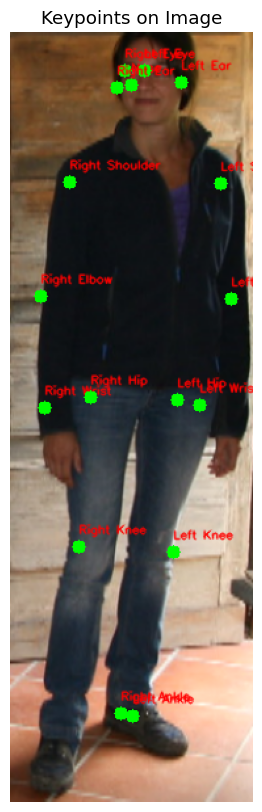

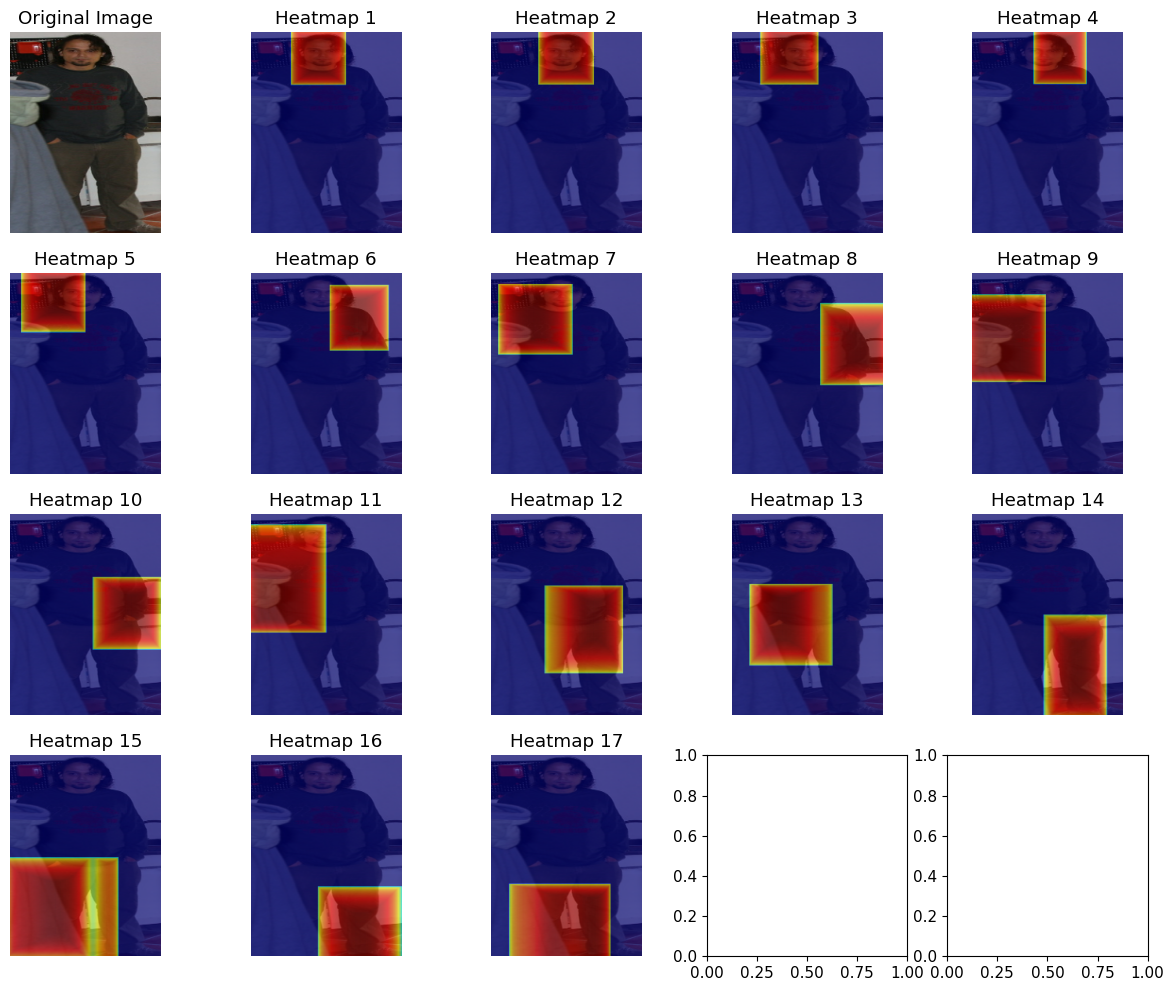

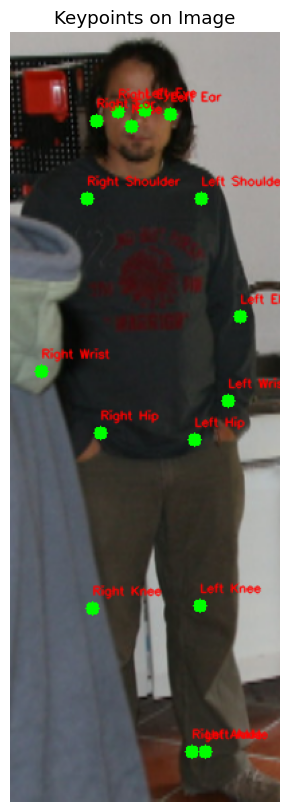

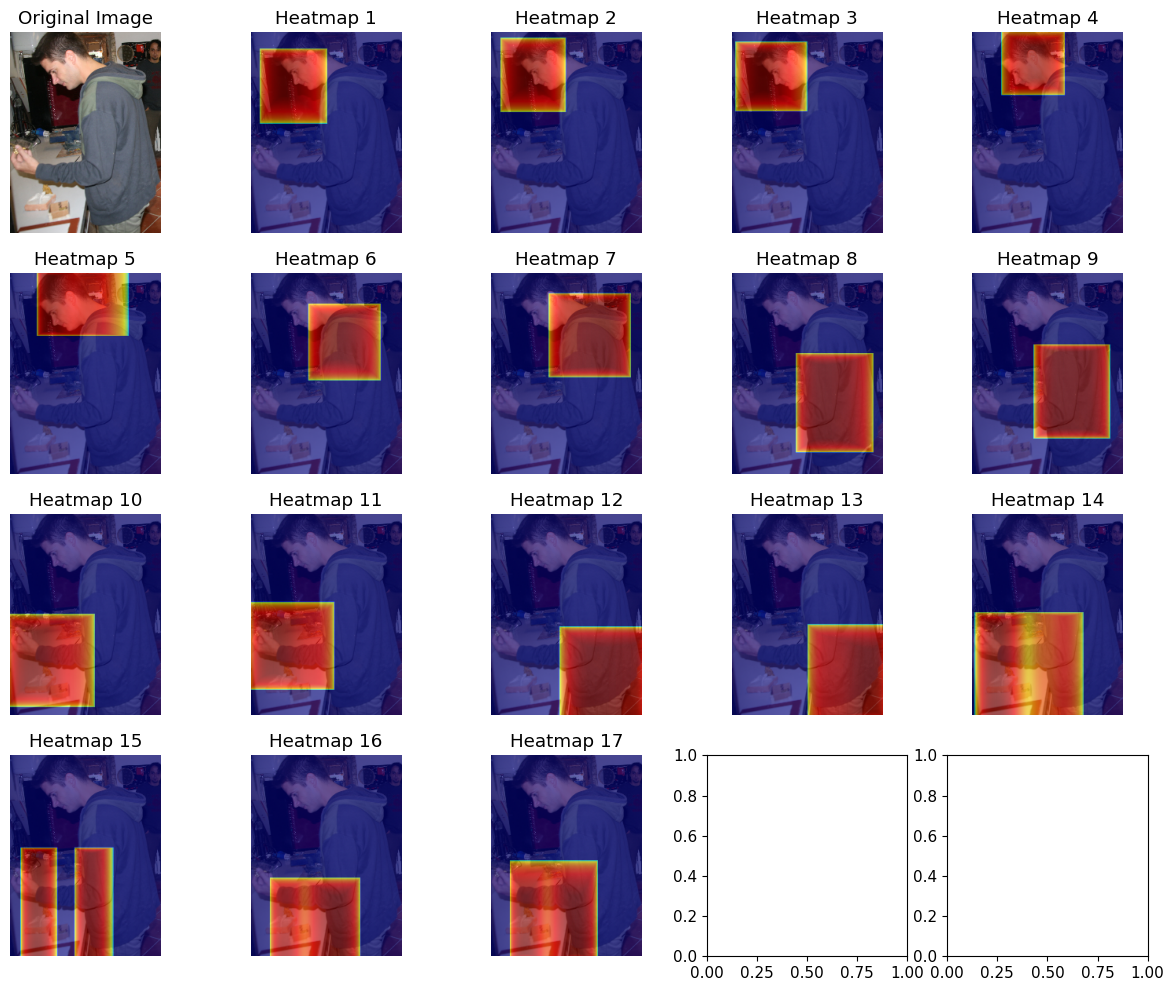

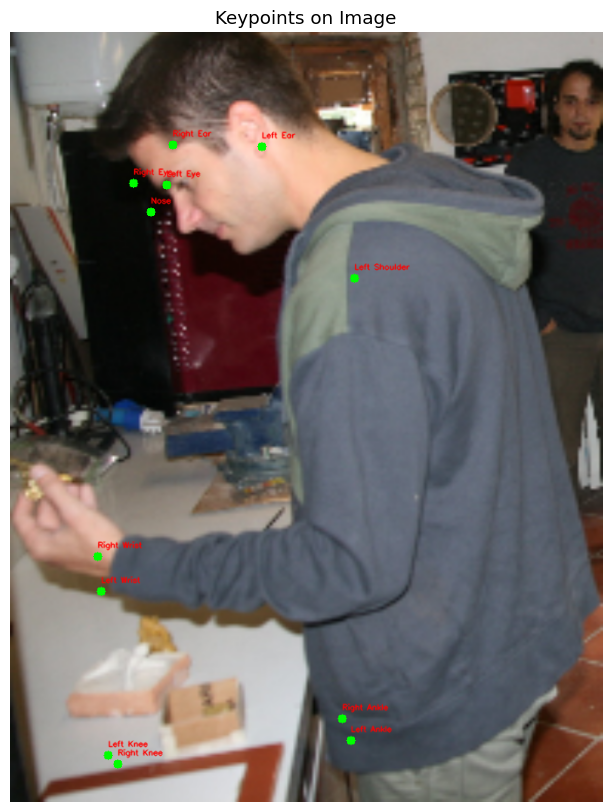

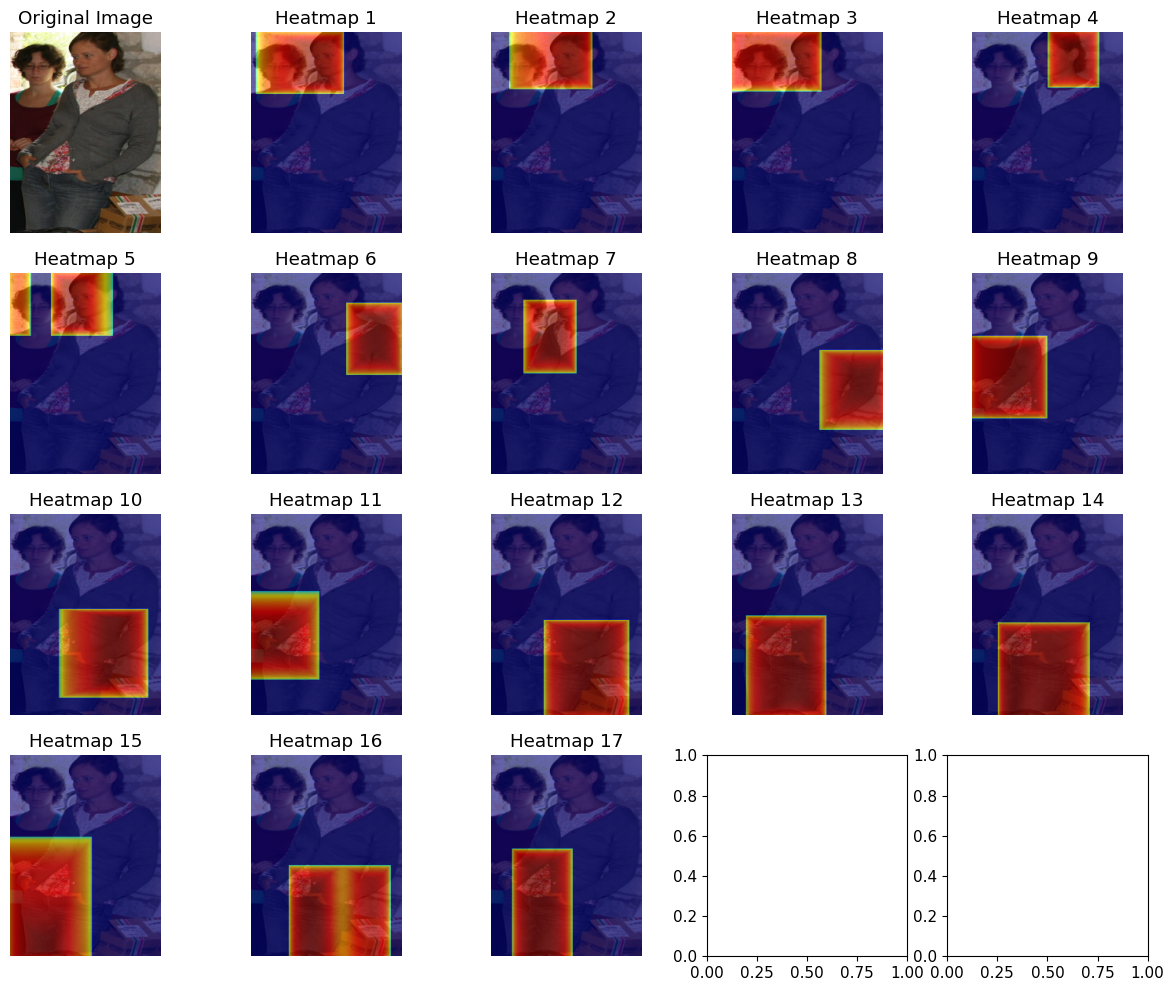

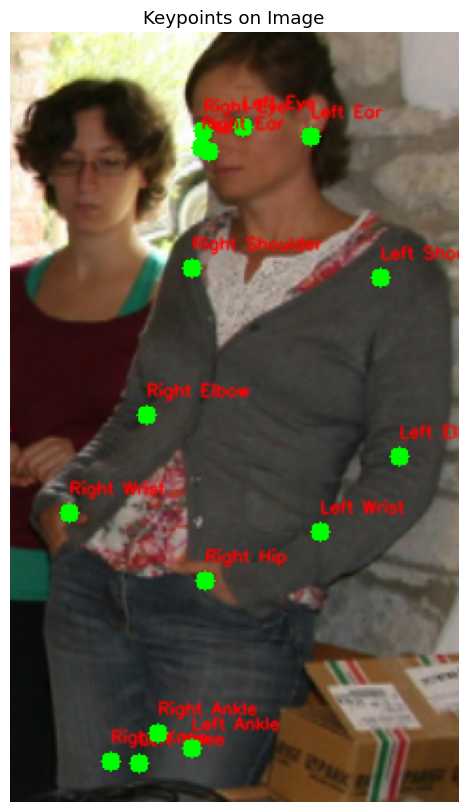

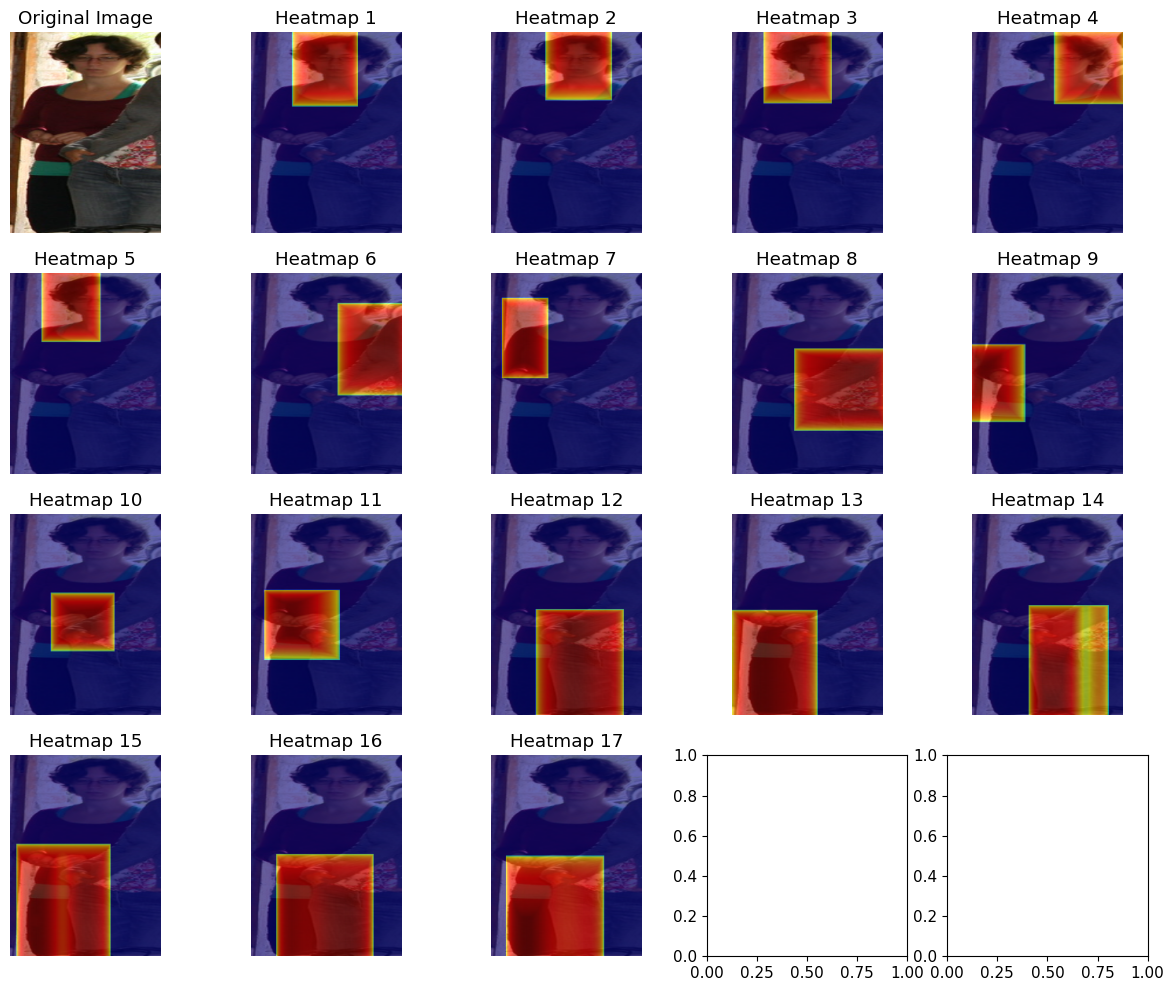

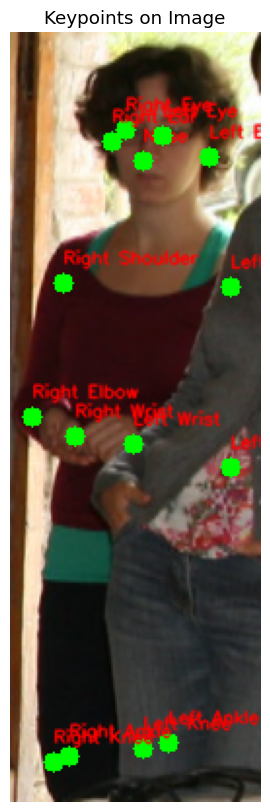

True

In [9]:
%matplotlib inline

joints_names = [
    "Nose", "Left Eye", "Right Eye", "Left Ear", "Right Ear",
    "Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow",
    "Left Wrist", "Right Wrist", "Left Hip", "Right Hip",
    "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"
]

orig_img = cv2.imread(img_path)

for idx, human_img in enumerate(human_images):
    orig_size = human_img.shape
    input_human_img = cv2.resize(human_img, (192, 256))
    input_human_img = input_human_img.transpose(2, 0, 1)
    input_human_img = input_human_img / 255.0
    input_human_img = np.expand_dims(input_human_img, axis=0)
    input_human_img = torch.tensor(np.array(input_human_img)).float()

    result = model.predict(input_human_img)
    labels, keypoints, eval = result
    simcc_x, simcc_y = labels
    scores, visibility = eval

    visualize_single_image_with_simcc_labels(input_human_img[0], keypoints[0], simcc_x[0], simcc_y[0], 4.0, visibility[0], joints_names, orig_size, orig_img, bboxes[idx])

cv2.imwrite('./results/people1.jpg', orig_img)